# Data Generation Procedure
1. Make an outcome function of the covariates. This functional relationship is the same for all units.

For each unit:

2. Each covariate is a arma process with lag 1 and 0.9 correlation, moving average =1, with a random starting point in the range 10, 1000.
3. Once all covariates have been computed for all all time steps, the outcome for each timestep is computed by inputting the covariate values into the outcome function.
4. Append to the bottom of the dataset.

In [1]:
import statsmodels as sm
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np
import pandas as pd
import random
import itertools
import string

class SimulateData(object):
    
    def __init__(self, n_donors, n_components, n_periods, treatment_period, treatment_effect=0):
        '''
        n_donors: int positive int. The number of potential control units, i.e. all units except the treated unit
        
        n_components: positive int. The number of covariates, or explanatory variables, in the dataset.
        The covariates columns are labeled "x0",...,"x(n-1)" if n_components=n
        These will the the right-most columns in the resulting dataset.
        
        n_periods: int >=2. The number of periods in which the outcome and covariates were observed.
        Equal to the maximum value in the "Time" column of the resulting dataset.
        
        treatment_period: int <n_periods. The first period in which the treated unit was exposed to the treatment.
        The treated unit is exposed to the treatment for every period in "Time" greater than or equal to treatment_period.
        
        treatment_effect: float. For each period after treatment_period, 
        the outcome of the treated unit is multiplied by (1+treatment_effect).
        Default=0.
        '''
        
        self.n_donors = n_donors
        self.n_components = n_components
        self.n_periods = n_periods
        
        assert treatment_period <= n_periods, "Treatment period must be 0< && <n_periods"
        self.treatment_period = treatment_period
        self.treatment_effect = treatment_effect

        self.coeffs = None #Stores coefficients of outcome function
        self.dataset = None #Stores dataset
        self.real_treatment_effect = None   #Array with value treatment_effect*treated_unit_outcome for every post-treatment period


    def make_component(self):
        '''
        Makes one covariate for one unit by adding an intercept, a linear trend and a sample from an arma model
        Values are arbitrary, but choosed to give positive series with trend and some noise
        Returns a list of length n_periods
        '''
        ar = np.r_[1, 0.9] #autoregressive component
        ma = np.array([100]) #moving-average component
        arma_process = ArmaProcess(ar, ma) #Define ARMA process
        arma_component = arma_process.generate_sample(nsample=self.n_periods) #Sample arma process
        
        additive_trend = np.random.normal(0, 300)
        trend = np.array([additive_trend*x for x in range(self.n_periods)])
        
        return random.randrange(10000, 10500) + np.add(arma_component, trend)
    
    def make_outcome_func(self, order):
        '''
        Chooses a subset of all possible terms of order<=order for n_components,
        Generates a random coefficient for each term, sampled from a lognormal(0, 25).
        Returns two 1-d arrays of equal size:
        terms with the indices of components that are to be multiplied
        coeffs with the coefficient by which the product of components will be weighted.
        
        order: Type:int. Gives the highest order terms that can be in the outcome function.
        For example, (x1, x1, x1) is a 3rd order term and (x1, x1) is a second order term.  
        Coefficients ~lognormal(0, 25) and divided by the order of the term to which they correspond
        '''
        
        #Record settings with which outcome func was created
        self.order = order
        
        #All first order terms are always included
        terms = list(range(self.n_components))
                
        #Generate list of all possible terms of 1< && <=self.order, given the number of components
        if self.order > 1:
            possible_terms = []
            for i in range(2, self.order+1):
                for term in itertools.combinations_with_replacement(list(range(self.n_components)), i):
                    possible_terms.append(term)
            #Select a subset of the possible terms to add to terms
            k = random.randint(1, len(possible_terms))
            higher_order_terms = random.sample(possible_terms, k)
            [terms.append(higher_order_terms[i]) for i in range(k)]

        #Create a random coeff for each term
        #Sampled from lognormal because coefficients are multiplicative
        coeffs = np.random.lognormal(0, 0.25, size=len(terms))
        for i in range(len(coeffs)):
            try: #If terms[i] has is of order 2<=, 
                 #divide by order of magnitude of covariate values ^ order
                 #Ensures contribution to outcome is of same order of magnitude as order1 terms
                coeffs[i] /= (10000 ** len(terms[i]))
            except: #if term[i] is first order, divide by 1
                continue
                
        #Store terms and coeff
        self.terms = terms
        self.coeffs = coeffs

    def compute_outcome(self, components, treated=False):
        '''
        Mutliplies each term by the associated coefficient for each observation
        Stores resulting value in outcome column y
        '''
        components = pd.DataFrame(np.array(components).T)
        
        result = np.zeros(components.shape[0])
        for coeff, term in zip(self.coeffs, self.terms):
            #If there term is only one component
            try:
                result += coeff * components.iloc[:, term]
                
            #If the term is multiple components
            except: 
                result += coeff * np.prod(components.iloc[:, list(term)], axis = 1)
                
        if treated: #Add the treatment effect for each observation in the post-treatment period
            self.real_treatment_effect = result[self.treatment_period] * self.treatment_effect
            result[self.treatment_period:] +=  self.real_treatment_effect
            
        return result

    def simulate_data(self, order):
        '''
        Makes data a panel dataset with treated unit 
        
        Format:
        Index, ID, Time, y, x1, x2,..., x_n
        '''
        #Set order and compute outcome func
        self.make_outcome_func(order)
        
        #Variables that are the same for each variable
        component_names = ["x%d"%num for num in range(self.n_components)]
        time = [x for x in range(self.n_periods)]

        #Make Treated unit
        components = [self.make_component() for _ in range(self.n_components)]
        dataset_dict = {component_names[x]: components[x] for x in range(self.n_components)}
        
        indices = [idx for idx in range(self.n_periods)]
        treated_id = np.full(self.n_periods, string.ascii_uppercase[0]) #Letter in Alphabet: A
        outcome = self.compute_outcome(components, True)
        self.dataset = pd.DataFrame({"ID":treated_id, 
                                     "Time":time, 
                                     "y":outcome},
                                     index=indices)
        
        #Make dataset
        temp_df = pd.DataFrame(dataset_dict, index=indices)
        self.dataset = pd.concat([self.dataset, temp_df], axis=1)

        #Make Control Units and concatenate to dataframe
        for donor in range(1, self.n_donors+1):
            components = [self.make_component() for _ in range(self.n_components)]
            donor_id = [string.ascii_uppercase[donor] for _ in range(self. n_periods)]
            outcome = list(self.compute_outcome(components, False))
            indices = [idx for idx in range(donor*self.n_periods, (donor+1)*self.n_periods)]
            temp_df1 = pd.DataFrame({"ID":donor_id, 
                                     "Time":time, 
                                     "y":outcome},
                                     index=indices)

            dataset_dict = {component_names[x]: components[x] for x in range(self.n_components)}
            temp_df2 = pd.DataFrame(dataset_dict, index=indices)
            #Append time and unit ID and Outcome to Dataframe
            control_df = pd.concat([temp_df1, temp_df2], axis=1)

            #Concatenate control_df to self.dataset
            self.dataset = pd.concat([self.dataset, control_df], sort=False)

# Pre-processing for Synthetic Difference-in-Differences

In [93]:
class DataTransformer(object):
    '''
    Takes an appropriately formatted, untransformed dataset and the location of the outcome variable
    returns dataset with changes computed for the outcome variable
    Ready to fit a Difference-in-Differences Synthetic Control
    
    There are 3 methods for computing changes:
    
    1. MeanSubtraction: Subtracting the mean of the associated variable and unit from every observation
    
    2. ChangeSubtraction: Subtracting the previous observation of variable and unit from every observation
        Note: There are only n-1 changes between n observations. 
        This makes the first observation a baseline at 0, expressing all other changes in reference thereto
    
    3. PercentageChange: Subtracting previous observation, then dividing by previous observation.
    '''
        
    def __init__(self, dataset, id_var, time_var):
        '''
        INPUT VARIABLES:
        
        dataset: the dataset for the synthetic control procedure.
        Should have the the following column structure:
        ID, Time, outcome_var, x0, x1,..., xn
        Each row in dataset represents one observation.
        The dataset should be sorted on ID then Time. 
        That is, all observations for one unit in order of Time, 
        followed by all observations by the next unit also sorted on time
        
        ID: a string containing a unique identifier for the unit associated with the observation.
        E.g. in the simulated datasets provided, the ID of the treated unit is "A".
        
        Time: an integer indicating the time period to which the observation corresponds.
        '''
        
        self.dataset = dataset
        self.id = id_var
        self.time = time_var
        
        #Use processing method to get
        self.transformed_data = None
        
    
    def mean_subtraction(self):
        '''
        Transformation method - MeanSubtraction: 
        Subtracting the mean from outcome and covariates for each unit from every observation
        
        Returns transformed ready to fit a Difference-in-Differences Synthetic Control        
        '''
        #Group by Unit, subtract columnwise mean of unit from each observation
        mean_subtract_cols = self.dataset.groupby(self.id).apply(lambda x: x - np.mean(x)).drop(columns=[self.time], axis=1)
        self.transformed_data = pd.concat([data[[self.id, self.time]], mean_subtract_cols], axis=1)

    def change_extraction(self):
        '''To be implemented: Uses pd.diff'''
        pass
    
    def pct_change_extraction(self):
        '''To be implemented:Uses pd.DataFrame.pct_change()'''
        pass

# Optimzation

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
from scipy.optimize import minimize, differential_evolution


class ControlSolver(object):
    
    def __init__(self, dataset, outcome_var, id_var, time_var, treatment_period, treated_unit, treatment_effect=None, w=None):
        '''
        INPUT VARIABLES:
        
        dataset: the dataset for the synthetic control procedure.
        Should have the the following column structure:
        ID, Time, outcome_var, x0, x1,..., xn
        Each row in dataset represents one observation.
        The dataset should be sorted on ID then Time. 
        That is, all observations for one unit in order of Time, 
        followed by all observations by the next unit also sorted on time
        
        ID: a string containing a unique identifier for the unit associated with the observation.
        E.g. in the simulated datasets provided, the ID of the treated unit is "A".
        
        Time: an integer indicating the time period to which the observation corresponds.
        
        treated_unit: ID of the treated unit
        '''
        
        self.dataset = dataset
        self.y = outcome_var
        self.id = id_var
        self.time = time_var
        self.treatment_period = treatment_period
        self.treated_unit = treated_unit
        self.treatment_effect = treatment_effect #If known
        #All columns not y, id or time must be predictors
        self.covariates = [col for col in self.dataset.columns if col not in [self.y, self.id, self.time]]

        #Extract quantities needed for reshaping matrices
        #Get number of periods in pre-treatment and total
        self.periods_pre_treatment = self.treatment_period - min(self.dataset[self.time])
        self.periods_all = max(self.dataset[self.time]) - min(self.dataset[self.time]) + 1
        #Number of control units, -1 to remove treated unit
        self.n_controls = len(self.dataset[self.id].unique()) - 1
        self.n_covariates = len(self.covariates)
        
        '''
        PROCESSED VARIABLES:
        
        treated_outcome: a (1 x treatment_period) matrix containing the
        outcome of the treated unit for each observation in the pre-treatment period.
        Referred to as Z1 in Abadie, Diamond, Hainmueller.
        
        control_outcome: a ((len(unit_list)-1) x treatment_period) matrix containing the
        outcome of every control unit for each observation in the pre-treatment period
        Referred to as Z0 in Abadie, Diamond, Hainmueller.
        
        treated_outcome_all: a (1 x len(time)) matrix
        same as treated_outcome but includes all observations, including post-treatment
        
        control_outcome_all: a (n_controls x len(time)) matrix
        same as control_outcome but includes all observations, including post-treatment
        
        treated_covariates: a (1 x len(covariates)) matrix containing the
        average value for each predictor of the treated unit in the pre-treatment period
        Referred to as X1 in Abadie, Diamond, Hainmueller.
        
        control_covariates: a (n_controls x len(covariates)) matrix containing the
        average value for each predictor of every control unit in the pre-treatment period
        Referred to as X0 in Abadie, Diamond, Hainmueller.
        
        W: a (1 x n_controls) matrix containing the weights assigned to each
        control unit in the synthetic control. W is contstrained to be convex,
        that is sum(W)==1 and ∀w∈W, w≥0, each weight is non-negative and all weights sum to one.
        Referred to as W in Abadie, Diamond, Hainmueller.
        
        V: a (len(covariates) x len(covariates)) matrix representing the relative importance
        of each covariate. V is contrained to be diagonal, positive semi-definite. 
        Pracitcally, this means that the product V.control_covariates and V.treated_covariates
        will always be non-negative. Further, we constrain sum(V)==1, otherwise there will an infinite
        number of solutions V*c, where c is a scalar, that assign equal relative importance to each covariate
        Referred to as V in Abadie, Diamond, Hainmueller.
        '''
        self.treated_outcome = None
        self.control_outcome = None
        self.treated_covariates = None
        self.control_covariates = None
        self.w = w #Can be provided if using Synthetic DID
        self.v = None
        
        
        self.treated_outcome_all = None
        self.control_outcome_all = None
        
        
        self.fail_count = 0 #Used to limit number of optimization attempts
    
    
    def transform_data(self):
        '''
        Takes an appropriately formatted, unprocessed dataset
        returns dataset with changes computed for the outcome variable
        Ready to fit a Difference-in-Differences Synthetic Control

        Transformation method - MeanSubtraction: 
        Subtracting the mean of the associated variable and unit from every observation
        '''
        mean_subtract_cols = self.dataset.groupby(self.id).apply(lambda x: x - np.mean(x)).drop(columns=[self.time], axis=1)
        return pd.concat([data[["ID", "Time"]], mean_subtract_cols], axis=1)
    
    def preprocess_data(self):
        '''
        Extracts processed variables from, excluding v and w, from input variables.
        These are all the data matrices.
        '''

        ###Get treated unit matrices first###
        treated_data_all = self.dataset[self.dataset[self.id] == self.treated_unit]
        self.treated_outcome_all = np.array(treated_data_all[self.y]).T.reshape(1, self.periods_all).T #All outcomes
        
        #Only pre-treatment
        treated_data = treated_data_all[self.dataset[self.time] < self.treatment_period]
        #Extract outcome and shape as matrix
        self.treated_outcome = np.array(treated_data[self.y]).T.reshape(1, self.periods_pre_treatment).T
        #Columnwise mean of each covariate in pre-treatment period for treated unit, shape as matrix
        self.treated_covariates = np.array(treated_data[self.covariates].mean(axis=0)).T.reshape(1, self.n_covariates).T
        
        ### Now for control unit matrices ###
        #Every unit that is not the treated unit is control
        control_data_all = self.dataset[self.dataset[self.id] != self.treated_unit]
        self.control_outcome_all = np.array(control_data_all[self.y]).T.reshape(self.n_controls, self.periods_all).T #All outcomes
        
        #Only pre-treatment
        control_data = control_data_all[self.dataset[self.time] < self.treatment_period]
        #Extract outcome, then shape as matrix
        self.control_outcome = np.array(control_data[self.y]).T.reshape(self.n_controls, self.periods_pre_treatment).T
        
        #Extract the covariates for all the control units
        #Identify which rows correspond to which control unit by setting index, 
        #then take the unitwise mean of each covariate
        #This results in the desired (n_control x n_covariates) matrix
        self.control_covariates = np.array(control_data[self.covariates].\
                set_index(np.arange(len(control_data[self.covariates])) // self.periods_pre_treatment).\
                mean(level=0)).T
        
    def total_loss(self, v_0, optimize=True):
        '''
        Solves for w*(v) that minimizes loss function 1 given v,
        Returns loss from loss function 2 with w=w*(v)
        '''
        V = np.zeros(shape=(self.n_covariates, self.n_covariates))
        np.fill_diagonal(V, v_0)
        
        # Construct the problem - constrain weights to be non-negative
        w = cvx.Variable((self.n_controls, 1), nonneg=True)
        
        #Define the objective
        objective = cvx.Minimize(cvx.sum(V @ cvx.square(self.treated_covariates - self.control_covariates @ w)))
        
        #Add constraint sum of weights must equal one
        constraints = [cvx.sum(w) == 1]
        
        #Solve problem
        problem = cvx.Problem(objective, constraints)
        
        try: #Try solving using current value of V, if it doesn't work return infinite loss
            result = problem.solve(verbose=False)
            loss = (self.treated_outcome - self.control_outcome @ w.value).T @ (self.treated_outcome - self.control_outcome @ w.value)
        except:
            return float(np.inf)
       
        
        #If optimize is true, just return the loss
        if optimize:
            return loss
        
        else:
            #print("Total loss:", np.round(loss, 3))
            #print("Optimal w:", np.round(w.value, 3))
            return w.value, loss
    
    
    def optimize(self, steps=5, verbose=False):
        #Initalize variable to track best w*(v)
        best_w, min_loss = None, float(np.inf)
        
        for step in range(steps):

            #Dirichlet distribution returns a valid pmf over n_covariates states
            v_0 = np.random.dirichlet(np.ones(self.n_covariates), size=1)

            #Required to have non negative values
            bnds = tuple((0,1) for _ in range(self.n_covariates))

            #res = minimize(self.total_loss, v_0, bounds=bounds, method="L-BFGS-B")
            res = minimize(self.total_loss, v_0, method='L-BFGS-B', bounds=bnds, 
                          options={'disp':3, 'iprint':3}) #, constraints=cons) method='L-BFGS-B' tol=1e-20
            
            if verbose:
                print("Successful:", res.success)
                print(res.message)

            #If optimization was successful
            if res.success:
                #Compute w*(v) and loss for v
                w, loss = self.total_loss(res.x, False)

                #See if w*(v) results in lower loss, if so update best
                if loss < min_loss:
                    best_w, min_loss = w, loss
                    
                    #Store best v from optimization
                    self.v = res.x
        
        #If sampler did not converge, try again up to 3 times before admitting defeat
        try:
            best_w[0]
        except:
            self.fail_count += 1
            if self.fail_count <= 3:
                self.optimize()
            
        #Save best w
        self.w = best_w
        
        #Return total loss
        return min_loss
    
    
    def diffevo_optimize(self):
        '''Uses the differential evolution optimizer from scipy to solve for synthetic control'''
        bounds = [(0,1) for _ in range(self.n_covariates)]

        result = differential_evolution(self.total_loss, bounds)
        
        self.v = result.x
        
        self.w, loss = self.total_loss(self.v, False)
        
        return self.w, loss


    def random_optimize(self, steps=10**4):
        '''
        "When intelligent approaches fail, throw spaghetti at the wall and see what sticks" - Benito Mussolini
        
        The below random samples valid v matrices from dirichlet distribution,
        then computes the resulting w*(v) and the total loss associated with it
        
        Returns the w*(v) that minimizes total loss
        '''
        #Initalize variable to track best w*(v)
        best_w, min_loss = None, float(np.inf)
        for i in range(steps):
            
            #Generate sample v
            #Dirichlet distribution returns a valid pmf over n_covariates states
            v = np.random.dirichlet(np.ones(self.n_covariates), size=1)
            
            #Print progress
            if (i+1)%steps/10 == 0:
                print('{}%'.format((i+1)%steps/10))
            
            #Compute w*(v) and loss for v
            w, loss = self.total_loss(v, False)
            
            #See if w*(v) results in lower loss, if so update best
            if loss < min_loss:
                best_w, min_loss = w, loss
        
        
        #Store, print, return best solutions
        self.w = best_w
        return best_w, min_loss
    
    def add_constant(self):
        '''Method used only by Synthetic Diff-in-Diff'''
        constant = np.mean(self.treated_outcome - self.control_outcome @ self.w)
        self.control_outcome_all += constant
    
    def get_post_treatment_rmspe(self):
        '''
        Computes post-treatment outcome for treated and synthetic control unit
        Subtracts treatment effect from treated unit
        
        Returns post-treatment RMSPE for synthetic control.
        Required: self.w must be defined.
        '''
        
        #Get true counter factual by subtracting the treatment effect from the treated unit
        true_counterfactual = self.treated_outcome_all[self.treatment_period:] - self.treatment_effect
        synth = self.control_outcome_all[self.treatment_period:] @ self.w
        return np.sqrt(((true_counterfactual - synth) ** 2).mean())
    
    
    def get_pre_treatment_rmspe(self):
        '''
        Computes pre-treatment outcome for treated and synthetic control unit
        
        Returns pre-treatment RMSPE for synthetic control.
        Required: self.w must be defined.
        '''
        
        return np.sqrt(((self.treated_outcome - self.control_outcome @ self.w) ** 2).mean())
    
    def plot(self):
        '''Plot the outcome of the Synthetic Unit against the Treated unit'''
        
        #Extract Synthetic Control
        synth = solver.w.T @ solver.control_outcome_all.T #Transpose to make it (n_periods x 1)
        time = self.dataset[self.time].unique()
        
        plt.figure(figsize=(12, 8))
        plt.plot(time, synth.T, 'r--', label="Synthetic Control")
        plt.plot(time ,self.treated_outcome_all, 'b-', label="Actual Data")
        plt.title("Example Synthetic Control Model")
        #Mark where the last treatment period was, the last time we expect equal values
        plt.axvline(self.treatment_period-1, linestyle=':', color="gray")
        plt.ylabel(self.y)
        plt.xlabel(self.time)
        plt.legend(loc='upper left')
        plt.show()

# Showing a few Examples

## First, the ordinary SCM

In [544]:
#Generate a dataset

#(self, n_donors, n_components, n_periods, treatment_period, treatment_effect)
data_generator = SimulateData(4, 2, 20, 15, 0.2)
data_generator.simulate_data(order=1)
data = data_generator.dataset
real_treatment_effect = data_generator.real_treatment_effect

/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:120: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:132: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Pre-treatment RMSPE: 301.28578220757555
Post-treatment RMSPE: 252.7722290304531


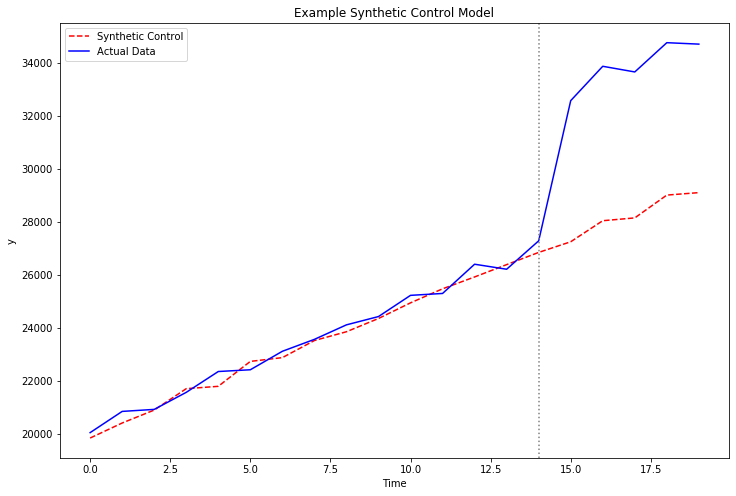

In [545]:
#Fit a SCM

solver = ControlSolver(data, "y", "ID", "Time", 15, "A", real_treatment_effect)
solver.preprocess_data()
solver.optimize()
print("Pre-treatment RMSPE:", solver.get_pre_treatment_rmspe())
print("Post-treatment RMSPE:", solver.get_post_treatment_rmspe())
solver.plot()

The dashed, gray, vertical line represents the last pre-treatment period. Every subsequent observation, the treated unit was exposed to the treatment.

# With Synthetic Difference-in-Differences

In [546]:
#Generate a dataset

#(self, n_donors, n_components, n_periods, treatment_period, treatment_effect)
data_generator = SimulateData(4, 2, 20, 15, 0.2)
data_generator.simulate_data(order=1)
data = data_generator.dataset
real_treatment_effect = data_generator.real_treatment_effect

In [547]:
#Pre-process by subtracting mean

transformer = DataTransformer(data, "ID", "Time")
transformer.mean_subtraction()

In [548]:
#Fit SCM to transformed data

transformed_solver = ControlSolver(transformer.transformed_data, "y", "ID", "Time", 15, "A", real_treatment_effect)
transformed_solver.preprocess_data()
transformed_solver.optimize(5)

/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:120: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:132: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(array([1., 0.]), array([[0.        ],
        [0.        ],
        [1.00000194],
        [0.        ]]), array([[49731536.5225476]]))

/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:120: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:132: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Pre-treatment RMSPE: 822.1117438774158
Post-treatment RMSPE: 569.2090766947804


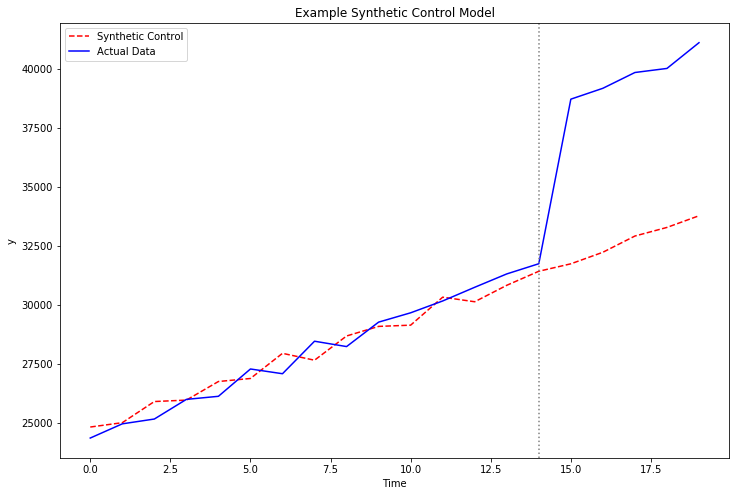

In [551]:
#Compute Synthetic Control using W from transformed data on untransformed data

solver = ControlSolver(data, "y", "ID", "Time", 15, "A", real_treatment_effect, transformed_solver.w)
solver.preprocess_data()
solver.add_constant() #Add the constant difference
print("Pre-treatment RMSPE:", solver.get_pre_treatment_rmspe())
print("Post-treatment RMSPE:", solver.get_post_treatment_rmspe())
solver.plot()

The dashed, gray, vertical line represents the last pre-treatment period. Every subsequent observation, the treated unit was exposed to the treatment.

# Comparing the models on post and pre-treatment RMSPE

# Datasets with outcomes that are linear in the covariates

In [38]:
#Make lists in which to store RMSPE results
scm_pre_order1 = []
scm_post_order1  = []

sdid_pre_order1  = []
sdid_post_order1  = []

steps = 500
failed_scm = np.zeros(steps)
failed_sdid = np.zeros(steps)

#failed_datasets = []

In [39]:
#Initalize data generator
#4 control units, 2 covariates, 20 periods (15-5 pre-post treatment split)
data_generator = SimulateData(4, 2, 15, 10, 0.2)

for step in range(int(len(scm_post_order1) + np.sum(failed_scm + failed_sdid)), steps):
    
    #Print progress
    if step % 10 == 0:
        print("{}%".format(step / 10))

    ###Simulate data - Same for both models for fair comparison##
    data_generator.simulate_data(order=1)
    data = data_generator.dataset
    real_treatment_effect = data_generator.real_treatment_effect

    ###Synthetic Difference-in-Differences###
    #Pre-process data for Synthetic Diff-in-Diff
    transformer = DataTransformer(data, "ID", "Time")
    transformer.mean_subtraction()
    transformed_data = transformer.transformed_data

    #Fit SCM to transformed data
    transformed_solver = ControlSolver(transformer.transformed_data, "y", "ID", "Time", 15, "A", real_treatment_effect)
    transformed_solver.preprocess_data()
    transformed_solver.optimize()

    #Compute Synthetic Control using W from transformed data on untransformed data
    solver = ControlSolver(data, "y", "ID", "Time", 10, "A", real_treatment_effect, transformed_solver.w)
    solver.preprocess_data()
    solver.add_constant() #Add the constant difference

    #Record SDID pre and post RMSPE
    try:
        solver.optimize()
        sdid_pre_order1.append(solver.get_pre_treatment_rmspe())
        sdid_post_order1.append(solver.get_post_treatment_rmspe())
    except:
        failed_sdid[step] = 1
        #failed_datasets.append(data)
        continue

    ###Repeat for Synthetic Control Model###
    #Fit Synthetic Control
    solver = ControlSolver(data, "y", "ID", "Time", 10, "A", real_treatment_effect)
    solver.preprocess_data()

    #Record SDID pre and post RMSPE
    try: #If one of the optimizers fail to converge
        solver.optimize()
        scm_pre_order1.append(solver.get_pre_treatment_rmspe())
        scm_post_order1.append(solver.get_post_treatment_rmspe())
    except:
        failed_scm[step] = 1
        #failed_datasets.append(data)

0.0%


/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:135: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


1.0%
2.0%
3.0%
4.0%
5.0%
6.0%
7.0%
8.0%
9.0%
10.0%
11.0%
12.0%
13.0%
14.0%
15.0%
16.0%
17.0%
18.0%
19.0%
20.0%
21.0%
22.0%
23.0%
24.0%
25.0%
26.0%
27.0%
28.0%
29.0%
30.0%
31.0%
32.0%
33.0%
34.0%
35.0%
36.0%
37.0%
38.0%
39.0%
40.0%
41.0%
42.0%
43.0%
44.0%
45.0%
46.0%
47.0%
48.0%
49.0%


## Summarizing results

In [102]:
scm_order1 = pd.DataFrame({"scm_pre":scm_pre_order1,
                          "scm_post": scm_post_order1})

sdid_order1 = pd.DataFrame({"sdid_pre":sdid_pre_order1,
                          "sdid_post": sdid_post_order1})


#Sometimes scm is really bad! But usually it is better
pd.concat([scm_order1.describe() , sdid_order1.describe()], axis=1)

,scm_pre,scm_post,sdid_pre,sdid_post
count,325.000000,325.000000,354.000000,354.000000
mean,937.818377,1884.325291,1032.072578,1606.703235
std,1094.646621,2554.916497,1196.342604,1517.180156
min,94.582647,73.763759,94.582647,86.724301
25%,301.191277,401.733065,304.258869,685.421933
50%,451.545852,721.684928,481.898190,1117.829272
75%,1185.834158,2585.045430,1393.505115,2037.563473
max,8167.948270,18521.998876,8201.111701,12015.284231


In [107]:
import statsmodels.stats.api as sms

#Confidence interval for mean RMSPE
print("Confidence interval mean of pre-treatment RMSPE for SCM:", sms.DescrStatsW(scm_order1["scm_pre"]).tconfint_mean())
print("Confidence interval mean of post-treatment RMSPE for SCM:", sms.DescrStatsW(scm_order1["scm_post"]).tconfint_mean())

print("Confidence interval mean of pre-treatment RMSPE for SDID:", sms.DescrStatsW(sdid_order1["sdid_pre"]).tconfint_mean())
print("Confidence interval mean of post-treatment RMSPE for SDID:", sms.DescrStatsW(sdid_order1["sdid_post"]).tconfint_mean())

Confidence interval mean of pre-treatment RMSPE for SCM: (818.36300841855, 1057.2737450716509)
Confidence interval mean of post-treatment RMSPE for SCM: (1605.5152301295084, 2163.1353521512424)
Confidence interval mean of pre-treatment RMSPE for SDID: (907.0197257010711, 1157.1254311840646)
Confidence interval mean of post-treatment RMSPE for SDID: (1448.113458124887, 1765.2930118648478)


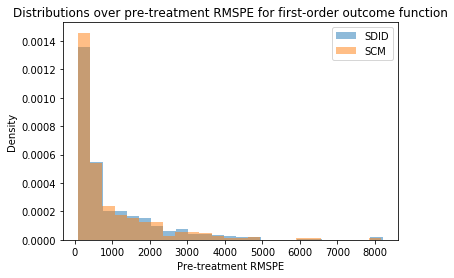

In [84]:
#Density=True to account for different sample sizes
plt.title("Distributions over pre-treatment RMSPE for first-order outcome function")
plt.hist(sdid_order1["sdid_pre"], bins=25, density=True, alpha=0.5, label = "SDID")
plt.hist(scm_order1["scm_pre"],bins=25, density=True, alpha=0.5, label = "SCM")
plt.legend(loc=0)
plt.ylabel("Density")
plt.xlabel("Pre-treatment RMSPE")
plt.show()

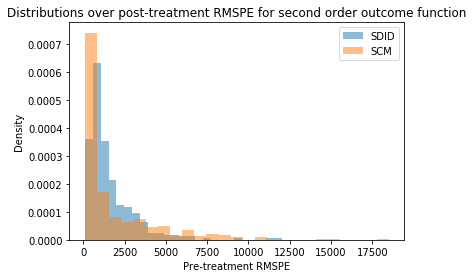

In [104]:
#Density=True to account for different sample sizes
plt.title("Distributions over post-treatment RMSPE for second order outcome function")
plt.hist(sdid_order1["sdid_post"], bins=25, density=True, alpha=0.5, label = "SDID")
plt.hist(scm_order1["scm_post"],bins=25, density=True, alpha=0.5, label = "SCM")
plt.legend(loc=0)
plt.ylabel("Density")
plt.xlabel("Pre-treatment RMSPE")
plt.show()

# Datasets where the outcome is a second-order function of the covariates

In [41]:
#Make lists in which to store RMSPE results
scm_pre_order2 = []
scm_post_order2  = []

sdid_pre_order2  = []
sdid_post_order2  = []

steps = 500
failed_scm_2 = np.zeros(steps)
failed_sdid_2 = np.zeros(steps)

In [43]:
#Initalize data generator
#4 control units, 2 covariates, 20 periods (15-5 pre-post treatment split)
data_generator = SimulateData(4, 2, 15, 10, 0.2)

for step in range(int(len(scm_post_order2) + np.sum(failed_scm_2 + failed_sdid_2)), steps):
    
    #Print progress
    if step % 10 == 0:
        print("{}%".format(step / 10))

    ###Simulate data - Same for both models for fair comparison##
    data_generator.simulate_data(order=2)
    data = data_generator.dataset
    real_treatment_effect = data_generator.real_treatment_effect

    ###Synthetic Difference-in-Differences###
    #Pre-process data for Synthetic Diff-in-Diff
    transformer = DataTransformer(data, "ID", "Time")
    transformer.mean_subtraction()
    transformed_data = transformer.transformed_data

    #Fit SCM to transformed data
    transformed_solver = ControlSolver(transformer.transformed_data, "y", "ID", "Time", 15, "A", real_treatment_effect)
    transformed_solver.preprocess_data()
    transformed_solver.optimize()

    #Compute Synthetic Control using W from transformed data on untransformed data
    solver = ControlSolver(data, "y", "ID", "Time", 10, "A", real_treatment_effect, transformed_solver.w)
    solver.preprocess_data()
    solver.add_constant() #Add the constant difference

    #Record SDID pre and post RMSPE
    try:
        solver.optimize()
        sdid_pre_order2.append(solver.get_pre_treatment_rmspe())
        sdid_post_order2.append(solver.get_post_treatment_rmspe())
    except:
        failed_sdid_2[step] = 1
        #failed_datasets.append(data)
        continue

    ###Repeat for Synthetic Control Model###
    #Fit Synthetic Control
    solver = ControlSolver(data, "y", "ID", "Time", 10, "A", real_treatment_effect)
    solver.preprocess_data()

    #Record SDID pre and post RMSPE
    try: #If one of the optimizers fail to converge
        solver.optimize()
        scm_pre_order2.append(solver.get_pre_treatment_rmspe())
        scm_post_order2.append(solver.get_post_treatment_rmspe())
    except:
        failed_scm_2[step] = 1
        #failed_datasets.append(data)

0.0%


/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:135: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


1.0%
2.0%
3.0%
4.0%
5.0%
6.0%
7.0%
8.0%
9.0%
10.0%
11.0%
12.0%
13.0%
14.0%
15.0%
16.0%
17.0%
18.0%
19.0%
20.0%
21.0%
22.0%
23.0%
24.0%
25.0%
26.0%
27.0%
28.0%
29.0%
30.0%
31.0%
32.0%
33.0%
34.0%
35.0%
36.0%
37.0%
38.0%
39.0%
40.0%
41.0%
42.0%
43.0%
44.0%
45.0%
46.0%
47.0%
48.0%
49.0%


## Summarizing results

In [103]:

scm_order2 = pd.DataFrame({"scm_pre":scm_pre_order2,
                          "scm_post": scm_post_order2})
sdid_order2 = pd.DataFrame({"sdid_pre":sdid_pre_order2,
                          "sdid_post": sdid_post_order2})

scm_order2.to_csv("scm_order2.csv", index=False)
sdid_order2.to_csv("sdid_order2.csv", index=False)

pd.concat([scm_order2.describe() , sdid_order2.describe()], axis=1)

,scm_pre,scm_post,sdid_pre,sdid_post
count,342.000000,342.000000,374.000000,374.000000
mean,791.208977,1559.147468,914.086710,1462.910642
std,930.354514,2141.170893,1079.622344,1311.239010
min,79.928440,84.666960,79.928405,138.606507
25%,284.833575,365.823335,289.545646,589.527625
50%,430.742181,686.304901,467.627085,1028.466443
75%,886.571328,1688.342241,1072.415114,1862.483861
max,6917.679682,14866.368259,6917.679682,8053.300503


In [106]:
#Confidence interval for mean RMSPE
print("Confidence interval mean of pre-treatment RMSPE for SCM:", sms.DescrStatsW(scm_order2["scm_pre"]).tconfint_mean())
print("Confidence interval mean of post-treatment RMSPE for SCM:", sms.DescrStatsW(scm_order2["scm_post"]).tconfint_mean())

print("Confidence interval mean of pre-treatment RMSPE for SDID:", sms.DescrStatsW(sdid_order2["sdid_pre"]).tconfint_mean())
print("Confidence interval mean of post-treatment RMSPE for SDID:", sms.DescrStatsW(sdid_order2["sdid_post"]).tconfint_mean())

Confidence interval mean of pre-treatment RMSPE for SCM: (692.2562740535247, 890.1616796093351)
Confidence interval mean of post-treatment RMSPE for SCM: (1331.4120796999553, 1786.8828571980341)
Confidence interval mean of pre-treatment RMSPE for SDID: (804.3136865536138, 1023.859733549382)
Confidence interval mean of post-treatment RMSPE for SDID: (1329.587474704207, 1596.233809693683)


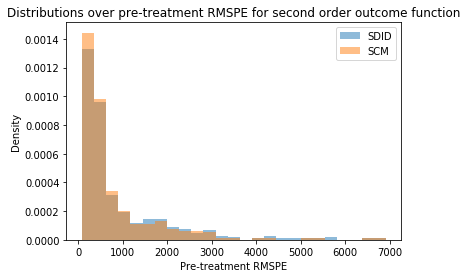

In [83]:
#Density=True to account for different sample sizes
plt.title("Distributions over pre-treatment RMSPE for second order outcome function")
plt.hist(sdid_order2["sdid_pre"], bins=25, density=True, alpha=0.5, label = "SDID")
plt.hist(scm_order2["scm_pre"],bins=25, density=True, alpha=0.5, label = "SCM")
plt.legend(loc=0)
plt.ylabel("Density")
plt.xlabel("Pre-treatment RMSPE")
plt.show()

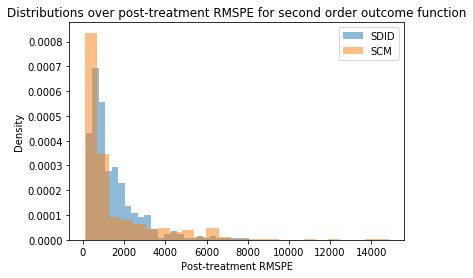

In [82]:
#Density=True to account for different sample sizes
plt.title("Distributions over post-treatment RMSPE for second order outcome function")
plt.hist(sdid_order2["sdid_post"], bins=25, density=True, alpha=0.5, label = "SDID")
plt.hist(scm_order2["scm_post"],bins=25, density=True, alpha=0.5, label = "SCM")
plt.legend(loc=0)
plt.ylabel("Density")
plt.xlabel("Post-treatment RMSPE")
plt.show()

# Reconstructing Fig.2 from Abadie, Diamond, Hainmueller 2015

Fig.2. Trends in per Capita GDP: West Germany versus Synthetic West Germany

Source: https://web.stanford.edu/~jhain/Paper/AJPS2015a.pdf?fbclid=IwAR1t38-sijOVIYUcpltDBs2gfTq2AV7Bw9xfDqv4saO2AGWMp8lla__3AOg'


This is mainly to show that the Synthetic Control implementation is not overly tailored to my synthetic data generation setup, but is directly compatible with any panel dataset that is structured like the industry standard.

In [552]:
data = pd.read_csv("/Users/oscarengelbrektson/Downloads/german_reunification.csv")
data = data.drop(columns="code", axis=1)

/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:120: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:132: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Pre-treatment RMSPE: 113.32584764854168


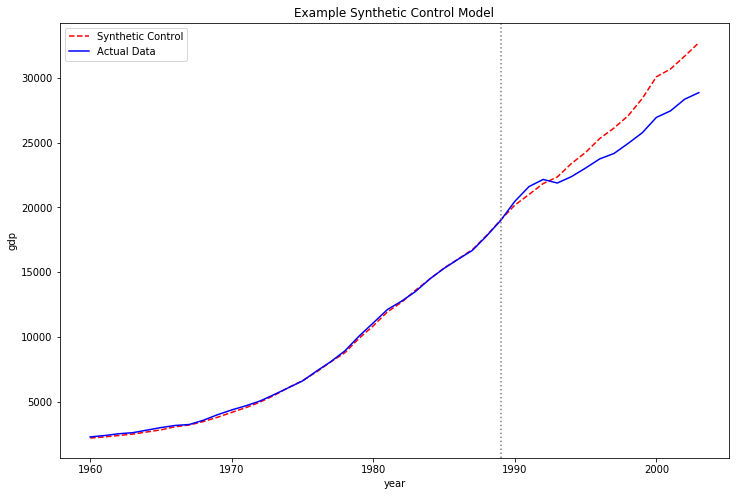

In [553]:
solver = ControlSolver(data, "gdp", "country", "year", 1990, "West Germany")
solver.preprocess_data()
solver.optimize()
print("Pre-treatment RMSPE:", solver.get_pre_treatment_rmspe())
solver.plot()

Disregard the legend and the title. This is supposed to be trends in per Capita GDP: West Germany versus Synthetic West Germany
